## Make sure to download the data before you start

In [ ]:
#!kaggle competitions download -c cassava-disease
# !ls data/
# !unzip test.zip -d data
# !unzip train.zip -d data

In [ ]:
import os
print(os.listdir('../data/Segmented/train/'))

In [ ]:
import fnmatch
import os
import numpy as np
import pandas as pd
#from keras.applications.nasnet import preprocess_input
#from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
np.random.seed(21)

path = '../data/train/'
train_label = []
train_img = []
label2num = {'cmd':0, 'cbsd':1, 'healthy':2, 'cgm':3, 'cbb':4}
for i in os.listdir(path):
    label_number = label2num[i]
    new_path = path+i+'/'
    for j in fnmatch.filter(os.listdir(new_path), '*.jpg'):
        temp_img = image.load_img(new_path+j, target_size=(128,128))
        train_label.append(label_number)
        temp_img = image.img_to_array(temp_img)
        train_img.append(temp_img)

train_img = np.array(train_img)

train_y=pd.get_dummies(train_label)
train_y = np.array(train_y)
train_img=preprocess_input(train_img)

print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)





In [4]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from livelossplot.keras import PlotLossesCallback
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.nasnet import NASNetLarge

def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(128,128,3))
    #model = NASNetLarge(input_shape=(331,331,3), include_top=False, weights='imagenet')
#     model = InceptionResNetV2(input_shape=(299,299,3),include_top=False, weights='imagenet')
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model



In [5]:

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score


In [6]:
from keras import backend as K
num_classes=5
model = vgg16_model(num_classes)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy',fscore])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

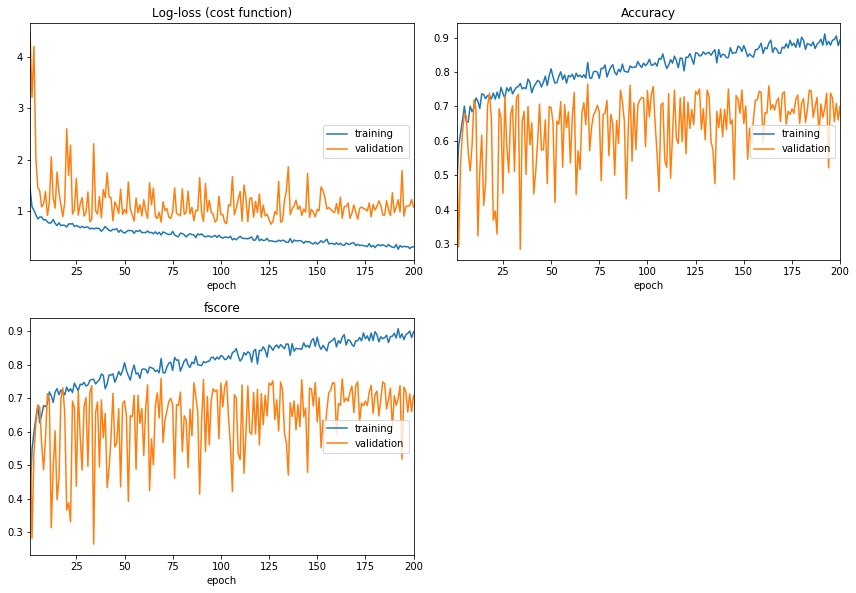

Log-loss (cost function):
training   (min:    0.261, max:    1.432, cur:    0.306)
validation (min:    0.748, max:    4.442, cur:    1.081)

Accuracy:
training   (min:    0.459, max:    0.911, cur:    0.893)
validation (min:    0.284, max:    0.765, cur:    0.701)

fscore:
training   (min:    0.385, max:    0.908, cur:    0.898)
validation (min:    0.264, max:    0.759, cur:    0.708)


In [7]:
#Split training data into rain set and validation set
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.1, random_state=42)

#Data augmentation
from keras.preprocessing.image import ImageDataGenerator
gen_train = ImageDataGenerator( 
    rotation_range=30,
    width_shift_range=0.2,
   height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True

)
gen_train.fit(X_train)

#Train model
epochs = 200
batch_size = 128
model_checkpoint = ModelCheckpoint('seg_vgg_weights.h5', monitor='val_loss', save_best_only=True)

# model.fit_generator(gen_train.flow(X_train, Y_train, batch_size=batch_size, shuffle=True), 
#                     steps_per_epoch=(X_train.shape[0]//(batch_size)), 
#                     epochs=epochs, 
#                     validation_data=(X_valid,Y_valid),
#                     callbacks=[model_checkpoint,PlotLossesCallback()],verbose=1)


# epochs = 100
# batch_size = 32
# model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

# model.fit(X_train,Y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), 
#           callbacks=[model_checkpoint,PlotLossesCallback()])





model.fit_generator(gen_train.flow(X_train, Y_train, batch_size=batch_size, shuffle=True), 
                    steps_per_epoch=(X_train.shape[0]//(4*batch_size)), 
                    epochs=(epochs), 
                    validation_data=(X_valid,Y_valid),
                    callbacks=[model_checkpoint,PlotLossesCallback()],verbose=1)


    
# model.fit_generator(gen_train.flow(train_img, train_y, batch_size=batch_size, shuffle=True), 
#                         steps_per_epoch=(X_train.shape[0]//(batch_size)), 
#                         epochs=10, 
#                         validation_data=(X_valid,Y_valid),
#                         callbacks=[model_checkpoint,PlotLossesCallback()],verbose=1)

    
    
    






In [ ]:
model.load_weights('seg_vgg_weights.h5')
print (model)

In [ ]:
prob=[]
num=[]
test_img=[]
test_path = '../data/test/0'
test_all = fnmatch.filter(os.listdir(test_path), '*.jpg')

test_img=[]
for i in range(len(test_all)):
    path=test_path+'/'+test_all[i]
    temp_img=image.load_img(path,target_size=(128,128))
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img) 
test_img=np.array(test_img)    
test_img=preprocess_input(test_img)


test_labels=[]
pred=model.predict(test_img)
num2label =  {0:'cmd', 1:'cbsd',2: 'healthy',3: 'cgm', 4:'cbb'}
for i in range(len(test_all)):
    max_score =0
    lab=-1
    for j in range(5):
        if pred[i][j]>max_score:
            max_score=pred[i][j]
            lab=j
    test_labels.append(num2label[lab])


d = {'Category': test_labels, 'Id': test_all}
df = pd.DataFrame(data=d)
print(df.head(5))

In [ ]:
print(df.head(50))

### To submit

In [ ]:
#Convert dataframe to csv
df.to_csv("submit.csv",index=False) 


#Submit the csv
print('Submitting csv .....')
!kaggle competitions submit cassava-disease -f submit.csv -m "Our first submission"

print('\nSubmittion Done Bye')